In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
select_year = 2017

## Open Data

In [3]:

input = './data/%d/preprocess.csv.xz' % select_year
df = pd.read_csv(input, compression='xz')
#df.info()

## SnowballStemmer

In [4]:
stemmer = SnowballStemmer("english")
df['titulo'] = df['titulo'].map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

## TF-IDF

In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=.0025, max_df=.1, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df['titulo'])

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



,term,weight
854,learn,0.016803
1442,softwar,0.015193
1201,problem,0.014903
952,method,0.014155
427,detect,0.013541
545,evalu,0.013395
1204,process,0.012890
433,develop,0.012832
299,comput,0.012765
1085,optim,0.012352


In [7]:
print('vocabulary:', len(tfidf_vectorizer.vocabulary_))
print('sparse matrix shape:', tfidf.shape)
print('nonzero count:', tfidf.nnz)
print('sparsity: %.2f%%' % (100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

vocabulary: 1729
sparse matrix shape: (3055, 1729)
nonzero count: 48396
sparsity: 0.92%


## NMF

In [8]:
nmf = NMF(n_components=50, solver="mu")
W = nmf.fit_transform(tfidf)
H = nmf.components_

idx_to_word = np.array(tfidf_vectorizer.get_feature_names())
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: classifi,forest,spectral,imag base,imag use,recognit,method,automat,segment,imag
Topic 2: agil,ecosystem,case,evalu,softwar engin,project,develop,softwar develop,engin,softwar
Topic 3: travel,neighborhood,schedul problem,search,rout problem,rout,solv,heurist,schedul,problem
Topic 4: generat,devic,low cost,cost,perform evalu,communic,low,perform,evalu,power
Topic 5: teach,object,base learn,machin learn,environ,machin,learn object,educ,learn environ,learn
Topic 6: free,number,threshold,complex,convex,path,modal,color,edg,graph
Topic 7: wireless network,rout,channel,network use,sink,industri,sensor network,wireless sensor,wireless,sensor
Topic 8: privaci,big,perform,plan,secur,environ,comput,cloud comput,servic,cloud
Topic 9: loop,simul,video,gpu,low,gpu base,schedul,real time,real,time
Topic 10: map studi,requir,systemat map,systemat review,systemat literatur,map,literatur review,literatur,review,systemat
Topic 11: immers,train,virtual environ,augment realiti,augment,3d,environ,

In [9]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names()
display_topics(nmf,idx_to_word,no_top_words)


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 45 words,Topic 45 weights,Topic 46 words,Topic 46 weights,Topic 47 words,Topic 47 weights,Topic 48 words,Topic 48 weights,Topic 49 words,Topic 49 weights
0,imag,2.648,softwar,2.510,problem,2.418,power,1.385,learn,2.554,...,inform,2.240,vehicl,1.354,interact,2.450,smart,1.584,ontolog,2.236
1,segment,1.022,engin,0.564,schedul,0.405,evalu,1.040,learn environ,0.437,...,dynam,0.991,unman,0.989,tool,0.480,citi,1.177,conceptu,0.587
2,automat,0.502,softwar develop,0.558,heurist,0.401,perform,1.035,educ,0.408,...,character,0.300,aerial,0.833,multimod,0.406,smart citi,1.047,pattern,0.465
3,method,0.318,develop,0.526,solv,0.392,low,0.577,learn object,0.398,...,privaci,0.231,aerial vehicl,0.799,human,0.362,plan,0.667,relat,0.436
4,recognit,0.310,project,0.458,rout,0.384,communic,0.436,machin,0.398,...,posit,0.230,unman aerial,0.793,user,0.276,urban,0.403,conceptu model,0.389
5,imag use,0.298,softwar engin,0.448,rout problem,0.353,perform evalu,0.366,environ,0.372,...,credit,0.211,case,0.579,transmiss,0.267,sink,0.257,domain,0.360
6,imag base,0.291,evalu,0.345,search,0.344,cost,0.353,machin learn,0.367,...,theori,0.203,traffic,0.558,induct,0.232,sens,0.236,organ,0.314
7,spectral,0.278,case,0.343,schedul problem,0.334,low cost,0.312,base learn,0.267,...,composit,0.194,case studi,0.543,generat,0.218,20,0.232,link,0.287
8,forest,0.267,ecosystem,0.343,neighborhood,0.292,devic,0.269,object,0.250,...,precis,0.182,use hybrid,0.383,law,0.210,iot,0.228,ontolog base,0.280
9,classifi,0.252,agil,0.311,travel,0.274,generat,0.245,teach,0.233,...,extract,0.175,data collect,0.356,execut,0.191,posit,0.218,languag,0.270


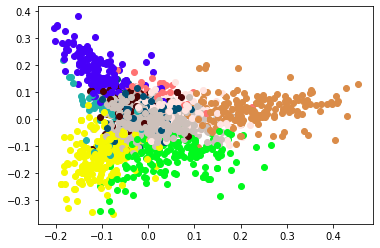

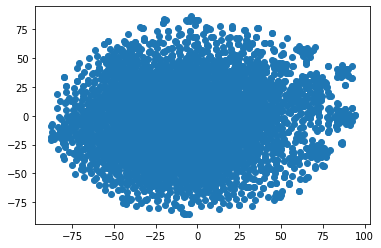

In [10]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(tfidf)
#print(labels)

X = tfidf.todense()

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
#print(reduced_data)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    #print(instance, index, labels[index])
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()